In [2]:
# Parameters
INPUT_FILE = './res/cleaned_rank.csv'
MAX_ORDER = 9
SCORE_LIST = [13,8,5,3,2,1,1,1,1]

assert len(SCORE_LIST) == MAX_ORDER

In [9]:
import pandas as pd
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

In [10]:
def replace_nan(data):
    """Replace NaN Value
        If a column contains numerical value, replace it with 0.
        Otherwise, replace it with 'UNKNOWN'"""
    
    df = data.copy()
    for col in df.columns:
        if df[col].dtype in ['int64', 'float64']:
            df[col].fillna(0, inplace = True)
        else:
            df[col].fillna('UNKNOWN', inplace = True)
    return df

In [11]:
pre_df = pd.read_csv(INPUT_FILE)

In [12]:
pre_df.head()

,รหัสนิสิต,pair 1,pair 2,pair 3,pair 4,pair 5,pair 6,pair 7,pair 8,pair 9,pair 10,pair 11,pair 12,pair 13,pair 14,pair 15,pair 16,pair 17,pair 18
0,6230149221,NaN,4.0,NaN,8.0,NaN,9.0,NaN,5.0,7.0,3.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,6.0
1,6332003721,NaN,6.0,NaN,5.0,7.0,3.0,9.0,NaN,NaN,1.0,NaN,NaN,4.0,8.0,NaN,NaN,2.0,NaN
2,6338092621,5.0,NaN,NaN,NaN,NaN,2.0,9.0,NaN,7.0,4.0,NaN,3.0,6.0,NaN,1.0,8.0,NaN,NaN
3,6331328521,2.0,NaN,NaN,NaN,8.0,7.0,6.0,NaN,4.0,9.0,NaN,5.0,NaN,NaN,3.0,NaN,NaN,1.0
4,6231208821,4.0,NaN,NaN,NaN,NaN,NaN,8.0,7.0,3.0,NaN,5.0,1.0,2.0,NaN,6.0,NaN,NaN,9.0


# Data Preprocessing

In [13]:
pre_df = replace_nan(pre_df)

In [14]:
score_transform = {k: v for k, v in zip(range(1, MAX_ORDER + 1), SCORE_LIST)}
df = pre_df.replace(score_transform)
df.head()

,รหัสนิสิต,pair 1,pair 2,pair 3,pair 4,pair 5,pair 6,pair 7,pair 8,pair 9,pair 10,pair 11,pair 12,pair 13,pair 14,pair 15,pair 16,pair 17,pair 18
0,6230149221,0.0,3.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,5.0,8.0,0.0,13.0,0.0,0.0,0.0,0.0,1.0
1,6332003721,0.0,1.0,0.0,2.0,1.0,5.0,1.0,0.0,0.0,13.0,0.0,0.0,3.0,1.0,0.0,0.0,8.0,0.0
2,6338092621,2.0,0.0,0.0,0.0,0.0,8.0,1.0,0.0,1.0,3.0,0.0,5.0,1.0,0.0,13.0,1.0,0.0,0.0
3,6331328521,8.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,1.0,0.0,2.0,0.0,0.0,5.0,0.0,0.0,13.0
4,6231208821,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,5.0,0.0,2.0,13.0,8.0,0.0,1.0,0.0,0.0,1.0


# Correlation Matrix

In [15]:
pair_score = df[[col for col in df if 'pair' in col]]
corr = pair_score.corr()
corr_table = corr.unstack().reset_index(name = 'Value')
corr_table.columns = ['#1', '#2', 'Value']
corr_table = corr_table[corr_table['#1'] != corr_table['#2']]
corr_table = corr_table.sort_values(by = 'Value', ascending=False)
# corr_table.head(30)

# Dendrogram

Text(0.5, 1.0, 'Dendrogram')

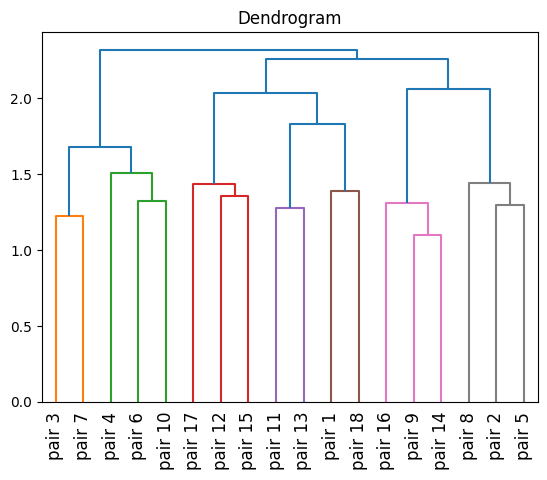

In [16]:
den = hierarchy.dendrogram(hierarchy.linkage(corr, method = 'ward'),
                           labels = corr.index,
                           leaf_rotation=90)
plt.title('Dendrogram')

In [138]:
# Final data to put into those unsupervised learning models
# pair_score.head()

# Principal Component Analysis

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca = PCA(n_components=2).fit(pair_score.T)

In [19]:
pca_score = pca.transform(pair_score.T)

# Explained variance ratio
pca.explained_variance_ratio_

array([0.18001808, 0.12068239])

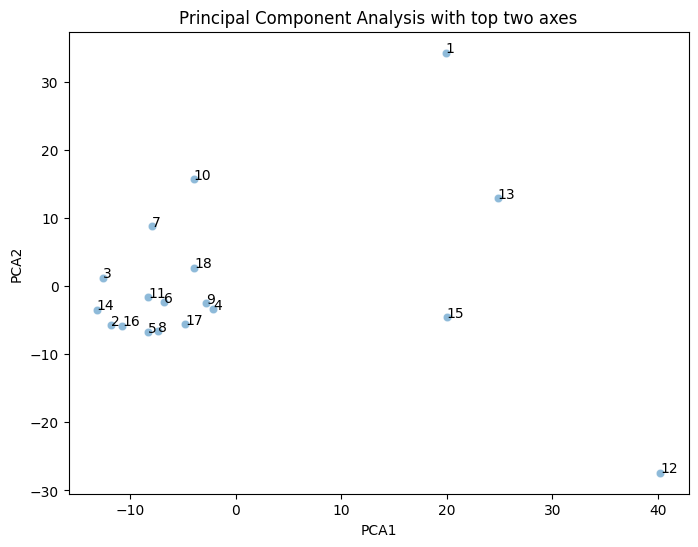

In [29]:
plt.figure(figsize = (8, 6))
sns.scatterplot(x = pca_score[:,0], y = pca_score[:,1], alpha = 0.5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Principal Component Analysis with top two axes')

# Annotate label for each dot
for i in range(pca_score.shape[0]):
    plt.annotate(str(i+1), (pca_score[i,0], pca_score[i,1]))

plt.show()

# Truncated Singular Value Decomposition

In [143]:
from sklearn.decomposition import TruncatedSVD

In [144]:
tsvd = TruncatedSVD(n_components=2, random_state=73).fit(pair_score.T)
tsvd_score = tsvd.transform(pair_score.T)

tsvd.explained_variance_ratio_

array([0.12066497, 0.12789656])

In [145]:
plt.figure(figsize = (8,6))
#plt.scatter(pca_score[:,0], pca_score[:,1])
sns.scatterplot(tsvd_score[:,0], tsvd_score[:,1], alpha = 0.5)
plt.xlabel('TSVD1')
plt.ylabel('TSVD2')
plt.title('Truncated SVD with n_components = 2')

# Annotate label for each dot
for i in range(tsvd_score.shape[0]):
    plt.annotate(str(i+1), (tsvd_score[i,0], tsvd_score[i,1]))

plt.show()

TypeError: scatterplot() takes from 0 to 1 positional arguments but 2 were given

<Figure size 800x600 with 0 Axes>

# Extra: Pair Score Sum

In [146]:
df.sum(axis = 0).iloc[1:].astype(int).sort_values(ascending = False)

pair 1     414
pair 13    389
pair 12    378
pair 15    348
pair 10    244
pair 9     218
pair 4     211
pair 7     193
pair 8     188
pair 5     171
pair 2     167
pair 18    165
pair 11    147
pair 3     136
pair 6     111
pair 17    110
pair 14    102
pair 16     53
dtype: int64

# 3D Plot from PCA

In [147]:
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler

In [148]:
pca_3x = PCA(n_components=3).fit(pair_score.T)
pca_3x_score = pca_3x.transform(pair_score.T)

print('Explained variance ratio: %.2f' % (sum(pca_3x.explained_variance_ratio_) * 100))

Explained variance ratio: 40.75


In [149]:
plt.figure(figsize = (10,10))
fig = px.scatter_3d(x = pca_3x_score[:, 0], y = pca_3x_score[:, 1],
                    z = pca_3x_score[:, 2], text = [str(i+1) for i in range(18)],
                    opacity = 0.3, title = '3D Principal Component Analysis Visualization')

# fig.update_layout(scene = dict(xaxis = dict(showgrid = False, showticklabels = False),
#                                yaxis = dict(showgrid = False, showticklabels = False),
#                                zaxis = dict(showgrid = False, showticklabels = False)))
# fig.show()

<Figure size 1000x1000 with 0 Axes>

In [150]:
fig.write_html("./img/pca_3d.html")

<h1>Brute Force</h1>

In [152]:
pairs = corr_table['#1'].unique()
combi = itertools.combinations(pairs, 3)
combi_list = [c for c in combi]

In [167]:
n = int(1e12)
all_rooms = []
for i in range(n):
    room = random.sample(combi_list, 6)
    if len(set(list(itertools.chain(*room)))) == 18:
        all_rooms.append(room)


KeyboardInterrupt: 

In [166]:
all_rooms

[]